<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/QUORA_MultiTask_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Sep  6 23:41:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install -q sentence_transformers

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 778kB 7.5MB/s 
     |████████████████████████████████| 890kB 11.9MB/s 
     |████████████████████████████████| 3.0MB 13.0MB/s 
     |████████████████████████████████| 1.1MB 59.2MB/s 


In [3]:
#basic 
import os
import random
import csv
import logging
import pandas as pd
from datetime import datetime

#plot
import seaborn as sns
import matplotlib.pyplot as plt

#sbert
from sentence_transformers import SentencesDataset, SentenceTransformer
from sentence_transformers import  evaluation, losses, util, LoggingHandler
from sentence_transformers.readers import InputExample

#torch
import torch
from torch.utils.data import DataLoader

In [4]:
# print logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [5]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/BERT/QUORA/quora-IR-dataset'

In [6]:
data = pd.read_csv(dataset_path+"/classification/train_pairs.tsv", sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
data = data.assign(question1 = data.question1.astype(str))
data = data.assign(question2 = data.question2.astype(str))
data = data.assign(is_duplicate = data.is_duplicate.astype(int))
data

,qid1,qid2,question1,question2,is_duplicate
0,161796,124097,When is surge pricing on Uber generally in eff...,When is surge pricing on Uber generally in eff...,0
1,123279,123280,Why in India do we not have one on one politic...,Why cant we have a public debate between polit...,1
2,63742,63743,What is the scope of making career in Import E...,"I'm a cartoonist, how can I start sharing my w...",0
3,13778,13779,What do you think will be the effect of Modi G...,What are the full implications of the Indian g...,1
4,266204,266205,What is OnePlus One?,How is oneplus one?,1
...,...,...,...,...,...
278312,190517,190518,"What is the meaning of the movie ""Pulp Fiction""?",Where can I find Pulp Fiction-like music?,0
278313,17705,228276,How do I commit suicide and make it seem like ...,I just want to die. How can I make it look lik...,1
278314,25202,25203,How can I beat procrastination?,What are some of the time tested ways to beat ...,1
278315,60188,102418,Why did some Quora answers collapse?,Why are my answers collapsed by Quora all the ...,1


## Viz. do balanceamento das Labels

Existem 174654 amostras não duplicadas ou 40.6%.       
Existem 103663 amostras duplicadas ou 59.4%.     


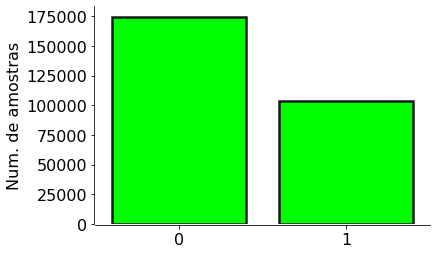

In [7]:
# plot
ax = sns.barplot(data['is_duplicate'].unique(), data['is_duplicate'].value_counts(), 
                 linewidth=2.5, facecolor=(0, 1, 0), edgecolor=".1")

# decoração
sns.despine(offset=1, trim=False)
sns.set_style("ticks")
ax.set_ylabel('Num. de amostras', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams['figure.figsize'] = (10,3)

duplicado = data['is_duplicate'].value_counts().tolist()[0]
nao_duplicado = data['is_duplicate'].value_counts().tolist()[1]

print(f'Existem {duplicado} amostras não duplicadas ou {(1-nao_duplicado/duplicado)*100 :.3}%.\
       \nExistem {nao_duplicado} amostras duplicadas ou {nao_duplicado/duplicado*100 :.3}%.\
     ')

In [8]:
train_samples_MultipleNegativesRankingLoss = []
train_samples_ConstrativeLoss = []

for row_data in data.iterrows():
    train_samples_ConstrativeLoss.append(
        InputExample(
            texts=[
                   row_data[1].question1, 
                   row_data[1].question2,
                  ], 
                  label=row_data[1].is_duplicate,
                  ))
    if row_data[1].is_duplicate == 1:
        train_samples_MultipleNegativesRankingLoss.append(
            InputExample(
                texts=[
                       row_data[1].question1, 
                       row_data[1].question2,
                      ], 
                      label=1,
                      ))
        train_samples_MultipleNegativesRankingLoss.append(
            InputExample(
                texts=[
                       row_data[1].question2, 
                       row_data[1].question1,
                      ], 
                      label=1,
                      ))  # se A é duplicidade de B, então B é duplicidade de A

# Para construir o dataset e dataloader é necessário instanciar o modelo (que faz a tokenização)

In [10]:
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

2020-09-07 02:10:25 - Load pretrained SentenceTransformer: distilbert-base-nli-stsb-mean-tokens
2020-09-07 02:10:25 - Did not find folder distilbert-base-nli-stsb-mean-tokens. Assume to download model from server.
2020-09-07 02:10:25 - Downloading sentence transformer model from https://sbert.net/models/distilbert-base-nli-stsb-mean-tokens.zip and saving it at /root/.cache/torch/sentence_transformers/sbert.net_models_distilbert-base-nli-stsb-mean-tokens


100%|██████████| 245M/245M [00:12<00:00, 19.5MB/s]


2020-09-07 02:10:41 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_distilbert-base-nli-stsb-mean-tokens
2020-09-07 02:10:41 - loading configuration file /root/.cache/torch/sentence_transformers/sbert.net_models_distilbert-base-nli-stsb-mean-tokens/0_Transformer/config.json
2020-09-07 02:10:41 - Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

2020-09-07 02:10:41 - loading weights file /root/.cache/torch/sentence_transformers/sbert.net_models_distilbert-base-nli-stsb-mean-tokens/0_Transformer/pytorch_model.bin
2020-09-07 02:10

In [11]:
BATCH_SZ = 64 # A MultipleNegativeLoss performa melhor com maiores batches

# Usar como métrica de distância de cosseno = 1-cosine_similarity)
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

#Pares negativos devem estar distantes a pelo menos 0.5
margin = 0.5

# Criando dataloader e instanciando a loss MultipleNegativesRankingLoss
train_dataset_MultipleNegativesRankingLoss = SentencesDataset(train_samples_MultipleNegativesRankingLoss, model=model)
train_dataloader_MultipleNegativesRankingLoss = DataLoader(train_dataset_MultipleNegativesRankingLoss, shuffle=True, batch_size=BATCH_SZ)
train_loss_MultipleNegativesRankingLoss = losses.MultipleNegativesRankingLoss(model)

# Criando o dataloader e instanciando a loss for OnlineContrastiveLoss
train_dataset_ConstrativeLoss = SentencesDataset(train_samples_ConstrativeLoss, model=model)
train_dataloader_ConstrativeLoss = DataLoader(train_dataset_ConstrativeLoss, shuffle=True, batch_size=BATCH_SZ)
train_loss_ConstrativeLoss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

# Avaliação do modelo em 3 tasks

> ## 1. Duplicate Questions pair classification
#### Dado (questão1 e questão2), são duplicadas ou não? Esse evaluator computará os embeddings de ambas questões e então calculará a semelhança de cossenos. Se a semelhança estiver acima do threshold, as questões são duplicadas.

> ## 2. Duplicate Questions Mining
#### Dado um grande corpus de questões, identificar todas as questões duplicadas no corpus.
> ## 3. Information Retrieval
#### Dada uma questão e um grande corpus (milhares de questões), encontrar a questão mais relevante (i.e. a questão duplicada) no corpus.

In [12]:
evaluators = []

## Task de classificação - evaluator 1

In [13]:
data_eval1 = pd.read_csv(dataset_path+"/classification/dev_pairs.tsv", sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
data_eval1 = data_eval1.assign(question1 = data_eval1.question1.astype(str))
data_eval1 = data_eval1.assign(question2 = data_eval1.question2.astype(str))
data_eval1 = data_eval1.assign(is_duplicate = data_eval1.is_duplicate.astype(int))
data_eval1.head(3)

,qid1,qid2,question1,question2,is_duplicate
0,188855,188856,How did Michel Foucault feel about surveillanc...,What is Michel Foucaults opinion on surveillan...,1
1,231741,231742,What's the difference between a consumer and a...,What is the difference between a customer and ...,0
2,188420,188421,If 3x + 9y = 7x + y. then 8y=?,"In India, why does most of society overpromise...",0


In [14]:
dev_sentences1 = data_eval1.question1.to_list()
dev_sentences2 = data_eval1.question2.to_list()
dev_labels = data_eval1.is_duplicate.to_list()

binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(
    dev_sentences1, 
    dev_sentences2, 
    dev_labels,
    )
evaluators.append(binary_acc_evaluator)

## Task de mineração - evaluator 2

In [15]:
data_eval2_corpus = pd.read_csv(dataset_path+"/duplicate-mining/dev_corpus.tsv", sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
data_eval2_corpus = data_eval2_corpus.assign(question = data_eval2_corpus.question.astype(str))
data_eval2_corpus.head(3)

,qid,question
0,216489,Why do some people get sexually aroused throug...
1,201577,Which is the safest city in the U.S?
2,199352,Has it ever happened to you that you were stud...


In [16]:
# Para rápido processamento vamos limitar o corpus em 10_000 sentenças.
max_dev_samples = 10_000
dev_sentences = {}

for row_data in data_eval2_corpus.iterrows():
    dev_sentences.update({row_data[1].qid: row_data[1].question})

    if len(dev_sentences) >= max_dev_samples:
        break

In [17]:
data_eval2_dup = pd.read_csv(dataset_path+"/duplicate-mining/dev_duplicates.tsv", sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
data_eval2_dup.head(3)

,qid1,qid2
0,54721,64378
1,333540,368414
2,164903,79019


In [18]:
dev_duplicates = []

for row_data in data_eval2_dup.iterrows():
    if row_data[1].qid1 in dev_sentences and row_data[1].qid2 in dev_sentences:
        dev_duplicates.append([row_data[1].qid1, row_data[1].qid2])

dev_duplicates[:5]        

[[198022, 215804],
 [163793, 282695],
 [182757, 276318],
 [174920, 78985],
 [130833, 34889]]

### O `ParaphraseMiningEvaluator` calcula a similaridade do cosseno entre todas as sentenças e extrai uma lista com os pares de maior similaridade. Dada a informação duplicatada em `dev_duplicates`, é  calculada a F$_1$ que mostra o quão bem a mineração duplicada performou.

In [19]:
paraphrase_mining_evaluator = evaluation.ParaphraseMiningEvaluator(
    dev_sentences, 
    dev_duplicates, 
    name='dev',
    )

evaluators.append(paraphrase_mining_evaluator)

## Task de recuperação da informação - evaluator 3

In [21]:
data_eval3_q = pd.read_csv(dataset_path+"/information-retrieval/dev-queries.tsv", sep='\t', encoding='utf8')
data_eval3_q = data_eval3_q.assign(qid = data_eval3_q.qid.astype(str))
data_eval3_q.head(3)

,qid,question,duplicate_qids
0,16,What should I do to be a great geologist?,15
1,101,Is Career Launcher good for RBI Grade B prepar...,102
2,103,Will a Blu Ray play on a regular DVD player? I...,104


In [22]:
max_corpus_size = 100_000

ir_queries = {}        # queries (qid: question)
ir_needed_qids = set() # conj. das qids que precisamos no corpus
ir_relevant_docs = {}  # mapeia os documentos relevantes oara uma dada query (qid: set([relevant_question_ids])

for row_data in data_eval3_q.iterrows():
    qid = row_data[1].qid
    query = row_data[1].question
    duplicate_ids = row_data[1].duplicate_qids.split(',')
    ir_queries[qid] = query
    ir_relevant_docs[qid] = set(duplicate_ids)
    for qid in duplicate_ids:
            ir_needed_qids.add(qid)

In [23]:
data_eval3_c = pd.read_csv(dataset_path+"/information-retrieval/corpus.tsv", sep='\t', encoding='utf8')
data_eval3_c = data_eval3_c.assign(qid = data_eval3_c.qid.astype(str))
data_eval3_c.head(3)

,qid,question
0,1,What is the step by step guide to invest in sh...
1,2,What is the step by step guide to invest in sh...
2,3,What is the story of Kohinoor (Koh-i-Noor) Dia...


In [24]:
ir_corpus = {} # o corpus (qid => question)

# Primeiro, obtenha todos os documentos relevantes necessários 
# (ou seja, devemos garantir que as questões relevantes estão realmente no corpus
distraction_questions = {}

for row_data_C in data_eval3_c.iterrows():
    qid = row_data_C[1].qid
    question = row_data_C[1].question

    if qid in ir_needed_qids:
        ir_corpus[qid] = question
    else:
        distraction_questions[qid] = question

# Agora, também adicionamos algumas questõees irrelevantes no corpus
other_qid_list = list(distraction_questions.keys())
random.shuffle(other_qid_list)

for qid in other_qid_list[0:max(0, max_corpus_size-len(ir_corpus))]:
    ir_corpus[qid] = distraction_questions[qid]


ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_queries, ir_corpus, ir_relevant_docs)
evaluators.append(ir_evaluator)

In [25]:
# Criando o SequentialEvaluator. Este SequentialEvaluator executa todos os três 
# avaliadores em uma ordem sequencial. Otimizamos o modelo em relação à pontuação 
# do último avaliador (pontuações [-1])

seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

In [26]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/BERT/QUORA/output/training_multi-task-learning'

In [27]:
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

2020-09-07 02:13:58 - Binary Accuracy Evaluation of the model on  dataset in epoch 0 after 0 steps:
2020-09-07 02:14:57 - Accuracy with Cosine-Similarity:           76.61	(Threshold: 0.8349)
2020-09-07 02:14:57 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7391)
2020-09-07 02:14:57 - Precision with Cosine-Similarity:          60.18
2020-09-07 02:14:57 - Recall with Cosine-Similarity:             81.64
2020-09-07 02:14:57 - Average Precision with Cosine-Similarity:  71.80

2020-09-07 02:14:57 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 193.7356)
2020-09-07 02:14:57 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.4903)
2020-09-07 02:14:57 - Precision with Manhatten-Distance:          59.75
2020-09-07 02:14:57 - Recall with Manhatten-Distance:             82.88
2020-09-07 02:14:57 - Average Precision with Manhatten-Distance:  71.86

2020-09-07 02:14:58 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8834)
2020-09

0.8631885593040585

# Trainamento do modelo

In [28]:
N_EPOCHS = 1

model.fit(train_objectives=[
                            (train_dataloader_MultipleNegativesRankingLoss, 
                             train_loss_MultipleNegativesRankingLoss), 
                            (train_dataloader_ConstrativeLoss, 
                             train_loss_ConstrativeLoss)
                            ],
          evaluator=seq_evaluator,
          epochs=N_EPOCHS,
          warmup_steps=1000,
          output_path=model_save_path,
          output_path_ignore_not_empty=True
          )


2020-09-07 02:46:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2020-09-07 02:47:25 - Accuracy with Cosine-Similarity:           83.42	(Threshold: 0.7873)
2020-09-07 02:47:25 - F1 with Cosine-Similarity:                 77.65	(Threshold: 0.7517)
2020-09-07 02:47:25 - Precision with Cosine-Similarity:          71.72
2020-09-07 02:47:25 - Recall with Cosine-Similarity:             84.65
2020-09-07 02:47:25 - Average Precision with Cosine-Similarity:  82.48

2020-09-07 02:47:25 - Accuracy with Manhatten-Distance:           83.25	(Threshold: 207.0246)
2020-09-07 02:47:25 - F1 with Manhatten-Distance:                 77.30	(Threshold: 230.1082)
2020-09-07 02:47:25 - Precision with Manhatten-Distance:          70.17
2020-09-07 02:47:25 - Recall with Manhatten-Distance:             86.05
2020-09-07 02:47:25 - Average Precision with Manhatten-Distance:  82.14

2020-09-07 02:47:25 - Accuracy with Euclidean-Distance:           83.27	(Threshold: 9.4179)
2020-09-07 02:47: